# Image Dataset Analysis and Preprocessing

Welcome! This project is a comprehensive exploration of modern Object detection, structured as a three-part end-to-end pipeline:

1. **Analysis and Preprocessing (Current Notebook)**: EDA, cleaning and transformation of raw XML data into machine-ready format.
2. **Custom Model from scratch**: Building a custom **Mini-YOLOv3** architecture from scratch.
3. **Transfer Learning**: Leveraging **YOLOv8** to achieve SOTA performance and compare it against the custom implementation.

---
For this project, the selected dataset will be [PASCAL Visual Object Classes (VOC) 2007](https://docs.ultralytics.com/es/datasets/detect/voc/#dataset-yaml).
It was selected because it's one of the most foundational datasets in computer history and used to validate the original YOLO paper.
* With **20 classes** and **~5000 trainin images** it's complex enough to be challenging while also being small to allow rapid iteration and experimentation on limited hardware.
* It uses **XML annotations**, which requires building a parsing pipeline, making it closer to real-world raw data.

The structure of the notebook will be:
1. Loading frameworks and preview
2. EDA
3. Preprocessing pipeline
4. Validation
---
Credits to:
* The data source, [PASCAL VOC 2007 Challenge](https://www.kaggle.com/datasets/stpeteishii/pascal-voc-2007-dataset).
* Kaggle's user [Olly Powell](http://kaggle.com/ollypowell), that inspired the EDA and Preprocessing by his own work in notebooks with similar pourpose.

## 1.1 Load frameworks

In [1]:
# EDA
import os
import xml.etree.ElementTree as ET
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
import random
import cv2 # OpenCV library
import matplotlib.pyplot as plt

## 1.2 Dataset Preview

Before doing anything, lets get some context about the dataset that will be used by showing some images from it. To do that, a helper function to plot the samples is defined:

--- PASCAL VOC 2007: Random Sample Preview ---


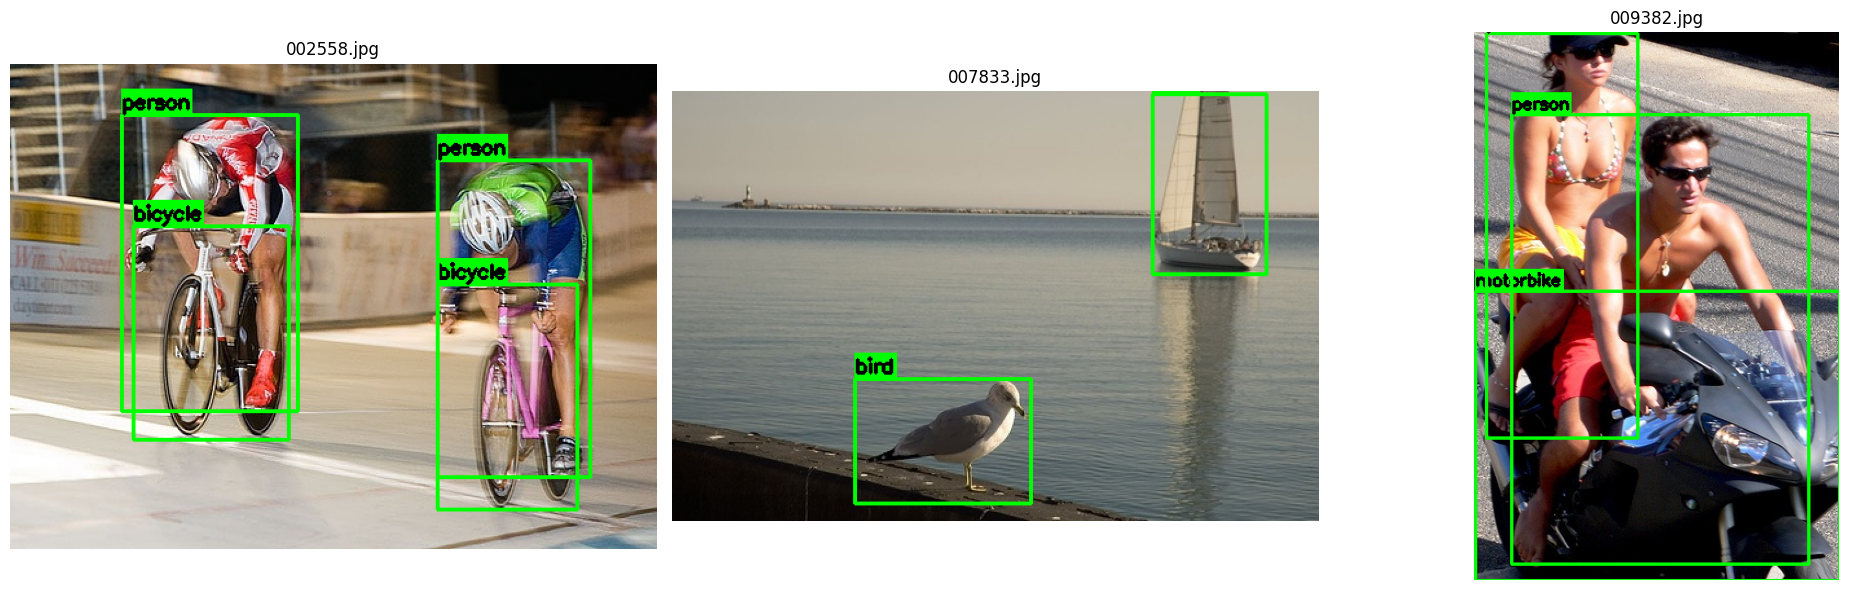

In [2]:
def plot_raw_samples(num_samples=4):
    """
    Picks random images, parses their original XML annotations,
    and displays them with bounding boxes.
    """
    # Define paths 
    input_path = '/kaggle/input/pascal-voc-2007-dataset/VOCdevkit2007/VOC2007/'
    annot_path = os.path.join(input_path, 'Annotations')
    img_path = os.path.join(input_path, 'JPEGImages')
    
    # Get all XML files
    xml_files = [f for f in os.listdir(annot_path) if f.endswith('.xml')]
    random_files = random.sample(xml_files, num_samples)
    
    # Setup plot
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 6))
    
    for i, file_name in enumerate(random_files):
        # 1. Parse XML
        tree = ET.parse(os.path.join(annot_path, file_name))
        root = tree.getroot()
        
        # Get image filename from XML
        image_name = root.find('filename').text
        full_img_path = os.path.join(img_path, image_name)
        
        # 2. Load Image
        image = cv2.imread(full_img_path)
        # Convert BGR (OpenCV) to RGB (Matplotlib)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # 3. Draw Boxes
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            bndbox = obj.find('bndbox')
            
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            
            # Draw Box (Green, thickness 2)
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            
            # Draw Label (with background for readability)
            text_size = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
            cv2.rectangle(image, (xmin, ymin - 20), (xmin + text_size[0], ymin), (0, 255, 0), -1)
            cv2.putText(image, class_name, (xmin, ymin - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            
        # 4. Display
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_name)
        
    plt.tight_layout()
    plt.show()

# Run the preview
print("--- PASCAL VOC 2007: Random Sample Preview ---")
plot_raw_samples(num_samples=3)

## 2. Exploratory Data Analysis


The annotations of each image, containing the information about the image, the bounding box etc. are in a `.xml` format. Let's inspect it to see what information contains each annotation.

In [3]:
# Path to annotations definition
annotations_path = '/kaggle/input/pascal-voc-2007-dataset/VOCdevkit2007/VOC2007/Annotations/'

# Pick one XML file to inspect
xml_file = annotations_path + '000005.xml' # this is the first file in the 'Annotations' folder

# Parse and print the file
tree = ET.parse(xml_file)
root = tree.getroot()

# Print the raw XML structure
print(ET.tostring(root, encoding='unicode'))


<annotation>
	<folder>VOC2007</folder>
	<filename>000005.jpg</filename>
	<source>
		<database>The VOC2007 Database</database>
		<annotation>PASCAL VOC2007</annotation>
		<image>flickr</image>
		<flickrid>325991873</flickrid>
	</source>
	<owner>
		<flickrid>archintent louisville</flickrid>
		<name>?</name>
	</owner>
	<size>
		<width>500</width>
		<height>375</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>chair</name>
		<pose>Rear</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>263</xmin>
			<ymin>211</ymin>
			<xmax>324</xmax>
			<ymax>339</ymax>
		</bndbox>
	</object>
	<object>
		<name>chair</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>165</xmin>
			<ymin>264</ymin>
			<xmax>253</xmax>
			<ymax>372</ymax>
		</bndbox>
	</object>
	<object>
		<name>chair</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>1</difficult>
		<bndbox>
			<xmin>

This is the XML structure for the annotations of each image. Here is the key information that it contains:

* `<filename>`: it tells to wich image file is related, in this case the image **'000005.jpg'**. Later matching them up will be necessary.
* `<size>`: describes the size of the image, in this case **width**: 500, **height**: 375.
    * This is relevant to later calculate the normalized coordinates by image size for **YOLO** architecture to work.
* `<object>`: it points out each object in the image. In the example there're multiple objects in the image, this information will be important to remember when parsing the dataset.
    * `<difficult>`(inside each object tag): it's a binary filter. The PASCAL VOC documentation states that objects marked as `difficult:1` are challenging to label (e.g., very occluded, unclear) and should be ignored during training.
    * Each `difficult: 0` object includes the class label `<name>` and the pixel coordinates `<bndbox>`: [xmin, ymin, xmax, ymax]

### 2.2 Class Distribution

Now to grasp each class distribution a loop through all the annotations file will be implemented.

Total number of files: 5011
Total objects found (non-difficult): 12608

 Class distribution:
Counter({'person': 4690, 'car': 1250, 'chair': 798, 'pottedplant': 514, 'dog': 510, 'bottle': 505, 'bird': 486, 'cat': 376, 'horse': 362, 'bicycle': 353, 'motorbike': 339, 'tvmonitor': 324, 'aeroplane': 306, 'train': 297, 'boat': 290, 'cow': 259, 'sheep': 257, 'sofa': 248, 'bus': 229, 'diningtable': 215})


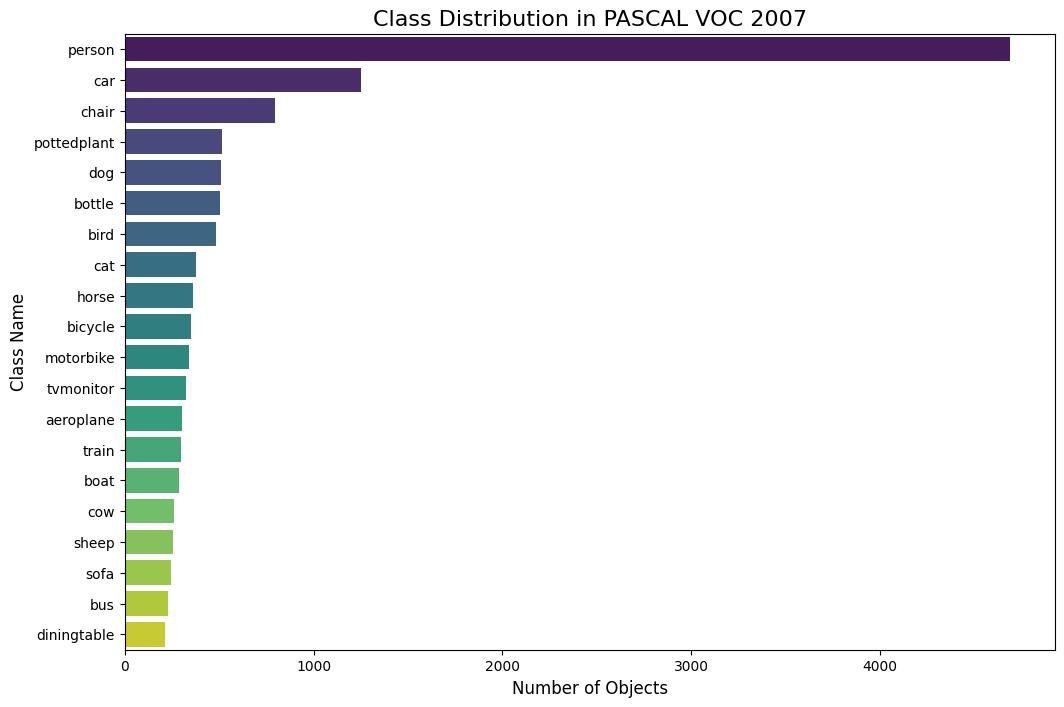

In [4]:
# Path for every single file in annotations folder
xml_files = [os.path.join(annotations_path, f) for f in os.listdir(annotations_path) if f.endswith('.xml')]
print("Total number of files:", len(xml_files))

# Initialize counter for each class in the annotation files
class_counts = Counter()

for file in xml_files:
    # Parse current file
    tree = ET.parse(file) # read the file and load it into a tree structure
    root = tree.getroot() # get the top tag (in this case <annotation>)

    # Find all <object> tags inside the current file
    for obj in root.findall('object'):

        # Check <difficult> tag
        difficult = obj.find('difficult')

        if difficult is None or difficult.text == '0':
            class_name = obj.find('name').text
            class_counts[class_name] += 1

print(f"Total objects found (non-difficult): {sum(class_counts.values())}")
print("\n Class distribution:")
print(class_counts)

# Distributions plot
class_df = pd.DataFrame(class_counts.most_common(), columns=["Class", "Count"])

plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Class', data=class_df, palette='viridis')
plt.title('Class Distribution in PASCAL VOC 2007', fontsize=16)
plt.xlabel('Number of Objects', fontsize=12)
plt.ylabel('Class Name', fontsize=12)
plt.show()

The dataset contains 5011 annotation files with 20 different classes trough all the images, being persons the object most detected and dining tables the least.

* **Person class** is the predominant one by a large number. This descompensation may cause problems of class imbalance.

### 2.3 Image Sizes

This is done to check the size of each image in regards of the correct adjustment of the bounding boxes later.

In [5]:
# Counter to store the width, height counts:
images_data = []

for file in xml_files:
    tree = ET.parse(file)
    root = tree.getroot()
    file_name = root.find('filename').text
    size_elem = root.find('size')

    # Extract width and height
    width = int(size_elem.find('width').text)
    height = int(size_elem.find('height').text)
    area = width * height

    images_data.append({
                    'ID': file_name,
                    'width': width,
                    'height': height,
                    'area': area
                })

images_df = pd.DataFrame(images_data)
print('Image sizes DataFrame (5 first rows)')
print(images_df.head())
print('\n Image sizes Data Statistics')
print(images_df.describe())

Image sizes DataFrame (5 first rows)
           ID  width  height    area
0  008753.jpg    500     437  218500
1  006625.jpg    500     375  187500
2  000802.jpg    500     375  187500
3  005450.jpg    357     500  178500
4  003031.jpg    500     375  187500

 Image sizes Data Statistics
             width       height           area
count  5011.000000  5011.000000    5011.000000
mean    472.703053   383.631411  178854.701257
std      57.577160    62.870358   20660.892036
min     127.000000    96.000000   48000.000000
25%     500.000000   334.000000  166500.000000
50%     500.000000   375.000000  187500.000000
75%     500.000000   375.000000  187500.000000
max     500.000000   500.000000  250000.000000


There's a high variety of image sizes, ranging from **minimum**: 127x96 pixels per image to **maximum**: 500x500. 

Normalization of the bounding box needs to be specific to each image.

###  2.4 Missing Values (Negative Images)

Now comes the inspection of the occurrence of negative images (images that have no objects in them).

In [6]:
# Counters
total_files = 0
negative_image_files = [] # to store the names of the files
positive_image_files = 0

for file in xml_files:
    total_files += 1
    object_count = 0 # Reset object count for the current file
    tree = ET.parse(file)
    root = tree.getroot()

    # Find all <object> tags
    for obj in root.findall('object'):

        # Check if <difficult> = 0
        difficult =obj.find('difficult')
        if difficult is None or difficult.text == '0':
            object_count += 1 # Valid, non-difficult object

    if object_count == 0: 
        negative_image_files.append(file) # This file has 0 non-difficult objects
    else:
        positive_image_files += 1

# Results
print(f"Total files checked: {total_files}")
print(f"Positive files (with objects): {positive_image_files}")
print(f"Negative files (no objects): {len(negative_image_files)}")
    
        

Total files checked: 5011
Positive files (with objects): 5011
Negative files (no objects): 0


This shows that all the images in the dataset contain objects.

### 2.5 Bounding Box Size Analysis

This analysis is done to understand the scale of objects in the image and possible labeling errors (i.e. 1x1 or 2x2 pixel boxes that probably are just mistakes).

* Collecting bounding boxes dimensions:

In [7]:
bbox_data = []

for file in xml_files:
    tree = ET.parse(file)
    root = tree.getroot()

    for obj in root.findall('object'):
        
        # Filter for non-difficult objects
        difficult = obj.find('difficult')
        if difficult is None or difficult.text == '0':

            class_name = obj.find('name').text

            # Get bounding box coordinates
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)

            # Calculate width, height and area
            bbox_width = xmax - xmin
            bbox_height = ymax - ymin
            bbox_area = bbox_width * bbox_height

            bbox_data.append({
                    'class': class_name,
                    'width': bbox_width,
                    'height': bbox_height,
                    'area': bbox_area
                })

# Convert the list of dicts to a DataFrame
bbox_df = pd.DataFrame(bbox_data)
print('Bounding box DataFrame (5 first rows)')
print(bbox_df.head())
print('\n Bounding box Data Statistics')
print(bbox_df.describe())

Bounding box DataFrame (5 first rows)
    class  width  height   area
0    bird    119      93  11067
1     car     35      26    910
2     car     59      72   4248
3     car     94      97   9118
4  person     50     113   5650

 Bounding box Data Statistics
              width        height           area
count  12608.000000  12608.000000   12608.000000
mean     157.792037    165.637532   34593.349064
std      126.803430    106.270156   41289.306413
min        8.000000      9.000000     171.000000
25%       57.000000     78.000000    4616.500000
50%      116.000000    142.000000   16865.000000
75%      226.000000    238.000000   50362.500000
max      499.000000    499.000000  235600.000000


**Minimum** bounding box values are 8x9 pixels, meaning that the dataset contains images with low scale objects. **Maximum** bounding box values are 499x499 pixels, almost as big as the image's full size (500x500). This means that the dataset contains images entirely filled with a single object. 

This proves that the model developped will need to be robust to a massive variation in object scale.

## 3. Preprocessing

From the **EDA** it is clear the structure of the dataset's labels, the `.xml` files that were seen previously. The CNN architecture that will be used for object detection - **YOLO**, expects a specif format for it to work. 

It requires a separate `.txt` file for each image. Inside that file, for each object there should be a line in this normalized format:

[class_id] [x_center_norm] [y_center_norm] [width_norm] [height_norm]


To achieve this objective, it will be broken down in three stages:

3.1. File Set Up

3.2. Label Conversion

3.3. Verification

### 3.1 File Set Up

Here the official train and validation splits will be readen to then define a new split of training and validation with the full paths to the `.jpg` images. Finally the `data.yaml` file will be created, to point to the new lists

* **Class Definition**:

This is inferred from the EDA, in alphabetical order.

In [8]:
CLASS_NAMES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
    'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

* **Original Data Splits Inspection**:

The PASCAL VOC dataset allready is splitted in **training and validation**. The lists that contain this information are in `ImageSets/Main/` folder. Inside the folder there are files per each object class and then `train.txt` and `val.txt`.These are the **'master lists'** containing the image's IDS for training and validation. 

Let's preview a .txt file to gain more intuition about the nature of the files that are going to be preprocessed.

In [9]:
# Path to a master list ImageSets/Main/ (train.txt)
source_train_file = '/kaggle/input/pascal-voc-2007-dataset/VOCdevkit2007/VOC2007/ImageSets/Main/trainval.txt'

# Print the first 10 lines
!head -n 10 {source_train_file}

000005
000007
000009
000012
000016
000017
000019
000020
000021
000023


* Files per each class object will be ignored as they were created for the original challenge to calculate the Average Precission of each class individually, not being meaningful for this project's scope. You can find the information in the [Official VOC 2007 Development Kit Doc (PDF)](https://data.brainchip.com/dataset-mirror/voc/VOC2007_doc.pdf). They contain the ID of each image and labels associated to whether there's the object of the current class or not, or if the object is labelled as difficult.

In [10]:
# Example with the aeroplane class (aeroplane_train.txt)
source_train_file = '/kaggle/input/pascal-voc-2007-dataset/VOCdevkit2007/VOC2007/ImageSets/Main/aeroplane_train.txt'

# Print the first 10 lines
!head -n 10 {source_train_file}

000012 -1
000017 -1
000023 -1
000026 -1
000032  1
000033  1
000034 -1
000035 -1
000036 -1
000042 -1


* `1` means image '000032', '000033'... contains a plane
*  `-1` means image '000012', '000017'... doesn't contain a plane
*  `0` (doesn't appear in the example) would mean the object is marked as **difficult**, and should be ignored.

Clarifications:

* Do not confuse the **'master list'** `train.txt` with the **train class object** `train_train.txt`.

* There's a last master list that wasn't mentioned earlier, `trainval.txt`. It contains the IDs from all the images in train.txt and val.txt combined. This would be used in the case that the model is trained with all the available data. That's not the current case as validation is inside the scope.

* **File Paths Definition**:

In [11]:
# Path to the Kaggle input directory
input_base_path = '/kaggle/input/pascal-voc-2007-dataset/VOCdevkit2007/VOC2007/'

# Path to the directory where images are stored
images_path = os.path.join(input_base_path, 'JPEGImages')

# Path to the ImageSets directory which contains train.txt, val.txt
image_sets_path = os.path.join(input_base_path, 'ImageSets', 'Main')

# Path to Kaggle's working directory (where the new files will be saved)
output_path = '/kaggle/working/'

* **Helper Function**:

The pourpose of this function is to build the 'master list' in the format that **YOLO** needs: the full path to each image (the original PASCAL VOC 'master list' just contains image IDs as seen earlier in the inspection).

In [12]:
def create_split_file(split_name):
    """
    Reads the 'split_name.txt' from ImageSets/Main/ and creates a new
    'split_name.txt' in the output_path with full paths to the .jpg files.
    """
    
    # Path to the official split file (e.g., .../ImageSets/Main/train.txt)
    source_file_path = os.path.join(image_sets_path, split_name + '.txt')
    
    # Path where the new file is saved (e.g., /kaggle/working/train.txt)
    output_file_path = os.path.join(output_path, split_name + '.txt')
    
    # Open our new output file in 'write' mode
    with open(output_file_path, 'w') as output_file:
        
        # Open the source ImageSet file in 'read' mode
        with open(source_file_path, 'r') as source_file:
            
            # Read each line in the source file
            for basename in source_file:
                # basename.strip() removes any whitespace/newlines
                image_name = basename.strip() + '.jpg'
                
                # Create the full, absolute path to the image
                full_image_path = os.path.join(images_path, image_name)
                
                # Write that full path as a new line in our output file
                output_file.write(full_image_path + '\n')

* **Master lists for training and validation**:

Now the helper function is applied in order to generate the 'master lists' for training and validation.

In [13]:
create_split_file('train')
create_split_file('val')

* **Data.yaml File definition**:

The last step of the set up is to create the `data.yaml` file. This file contains all the information regarding the paths to each image for training and validation ('master lists'), aswell as the object classes that appear in the images.

In [14]:
# Create the data.yaml file
yaml_path = os.path.join(output_path, 'data.yaml')

# Write the YAML content
with open(yaml_path, 'w') as f:
    f.write(f"train: {os.path.join(output_path, 'train.txt')}\n")
    f.write(f"val: {os.path.join(output_path, 'val.txt')}\n")
    f.write("\n")
    f.write(f"nc: {len(CLASS_NAMES)}  # number of classes\n")
    f.write(f"names: {CLASS_NAMES}  # class names\n")

### 3.2 Label Conversion

This is the core of preprocessing, where the XML labels will be translated into the YOLO .txt format.

* **Configuration**:

The definition of the paths for the labels and annotations will be done now.

In [15]:
# The annotations file was defined during the EDA, but will be redefined now in case it wasn't executed earlier
annotations_path = os.path.join(input_base_path, 'Annotations')

# Define the new directory where the .txt labels will be saved
labels_dir_path = os.path.join(output_path, 'labels')

# Create the label directory explicitly
os.makedirs(labels_dir_path, exist_ok=True)

* **Read the master lists at the output direction**:

This is done to combine both lists of paths onto a single one of all the images needed to be processed.

In [16]:
# Read the train and validation files created earlier

with open(os.path.join(output_path, 'train.txt'), 'r') as f:
    train_image_paths = f.read().splitlines()
        
with open(os.path.join(output_path, 'val.txt'), 'r') as f:
    val_image_paths = f.read().splitlines()

# Combine them into one single list
all_image_paths = train_image_paths + val_image_paths

* **Conversion Function**:

This is what the function will do for a single image:

1. Given an image path, find its matching XML file.
2. Parse the XML file to find the image's height and width.
3. Find all 'non difficult' object tags.
4. For each object:
   * Get the class name and create a `class_id` from the CLASS_NAMES list created earlier.
   * Get the pixel coordinates [xmin, ymin, xmax, ymax] and convert them into the YOLO format [x_center_norm, y_center_norm, width_norm, height_norm].
   * Save the normalized information into a new text file.

In [17]:
def convert_annotation(image_path):
    """
    Reads an image path, finds its matchig XML and saves a new
    YOLO formatted .txt label file in the 'labels/' directory.
    """
    try:
        # 1. Find the XML path
        basename = os.path.splitext(os.path.basename(image_path))[0] # Gets the file name, splits it from the extension and takes the first part of the tuple
        xml_path = os.path.join(annotations_path, basename + '.xml')
    
        # 2. Find the destination .txt path
        label_path = os.path.join(labels_dir_path, basename + '.txt')
    
        # 3. Parse the XML
        tree = ET.parse(xml_path)
        root = tree.getroot()
    
        # 4. Get image size for normalization
        size_elem = root.find('size')
        img_width = int(size_elem.find('width').text)
        img_height = int(size_elem.find('height').text)
    
        # Loop through objects and convert
        yolo_labels = []
    
        for obj in root.findall('object'):
    
            # Check 'difficult' label
            difficult = obj.find('difficult')
            if difficult is not None and difficult.text == '1':
                continue # Skip this object
    
            # Get class name and ID
            class_name = obj.find('name').text
            class_id = CLASS_NAMES.index(class_name) # map class name with the list of all classes ordered alphabet.
    
            # Get pixel coordinates
            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)
    
            # Convert from [min, max] to [center, width]
            x_center = (xmin + xmax) / 2.0
            y_center = (ymin + ymax) / 2.0
            width = xmax - xmin
            height = ymax - ymin
    
            # Normalize coordinates (0.0 - 1.0 range)
            x_center_norm = x_center / img_width
            y_center_norm = y_center / img_height
            width_norm = width / img_width
            height_norm = height / img_height
    
            # Format the YOLO string and add it to list
            yolo_labels.append(
                f"{class_id} {x_center_norm} {y_center_norm} {width_norm} {height_norm}"
            )
    
        # Save the new .txt file - all object lines are joined with a newline character
        with open(label_path, 'w') as f:
            f.write("\n".join(yolo_labels))
    except Exception as e:
        print(f"\n[WARNING] Failed to process {image_path}. Error: {e}")
        print("Skipping this file.")

* **Convert all files**:

For the last task of label conversion, the process will be to iterate through the list containing all image paths and run the conversion function on every single file. To visualize the progress, `tqdm` is used.

In [18]:
for i, img_path in enumerate(all_image_paths):
    convert_annotation(img_path)
    
    if (i + 1) % 1000 == 0:
        print(f"Processed {i + 1} images...")

print("Label conversion complete.")

Processed 1000 images...
Processed 2000 images...
Processed 3000 images...
Processed 4000 images...
Processed 5000 images...
Label conversion complete.


Now all XML files are converted to a YOLO format and ready to be used for training.

## 4. Validation

This is the last step of preprocessing, to ensure that the process of normalizing the bounding boxes was done correctly. For that, to a number of random images the new .txt **label conversion files** will be readen to then reverse the normalization of the bounding boxes and draw the result on the images to check if the boxes line up. All with the help of the `OpenCV` library.

* **Visualization Function**:

This function is the one that will get as input an image, find its label and parse the YOLO format to then reverse the normalization math to draw the bounding box, with the help of `cv2()` -  **OpenCV library**.

In [19]:
def show_verification_image(image_path):
    """
    Loads an image, reads its corresponding YOLO .txt label, draws the
    bounding boxes and displays it.
    """

    # Load the image with OpenCV
    image = cv2.imread(image_path) # the image will be in BGR color format

    # Get image dimensions 
    img_height, img_width, _ = image.shape

    # Find the matching label file
    basename = os.path.splitext(os.path.basename(image_path))[0]
    label_path = os.path.join(labels_dir_path, basename + '.txt')

    # Read and draw labels
    try:
        with open(label_path, 'r') as f:
            lines =f.read().splitlines()

        if not lines:
            print("This is a 'negative' image (empty label file).")

        for line in lines:
            # Parse the YOLO format
            parts = line.split()
            class_id = int(parts[0])
            x_center_norm = float(parts[1])
            y_center_norm = float(parts[2])
            width_norm = float(parts[3])
            height_norm = float(parts[4])

            # Reverse the math - convert normalized coords. back to pixel values
            x_center_pix = x_center_norm * img_width
            y_center_pix = y_center_norm * img_height
            width_pix = width_norm * img_width
            height_pix = height_norm * img_height

            # Convert to [xmin, ymin, xmax, ymax]
            xmin = int(x_center_pix - width_pix / 2)
            ymin = int(y_center_pix - height_pix / 2)
            xmax = int(x_center_pix + width_pix / 2)
            ymax = int(y_center_pix + height_pix / 2)

            # Get the class name
            label_name = CLASS_NAMES[class_id]

            # Draw the bounding box
            # Green color - (0, 255, 0) , thickness = 2
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

            # Draw label text
            cv2.putText(
                image,
                label_name,
                (xmin, ymin - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6, # Font scale
                (0, 255, 0), # Font color
                2 # Font thickness
            )

    except FileNotFoundError:
        print("This is a 'negative' image (no .txt label file found).")

    # Display the image
    plt.figure(figsize=(10, 10))

    # Convert BGR to RGB (Matplotlit predet. format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb)
    plt.axis('off') # Hide the x/y axes
    plt.show()

* **Verification in 5 random images**:

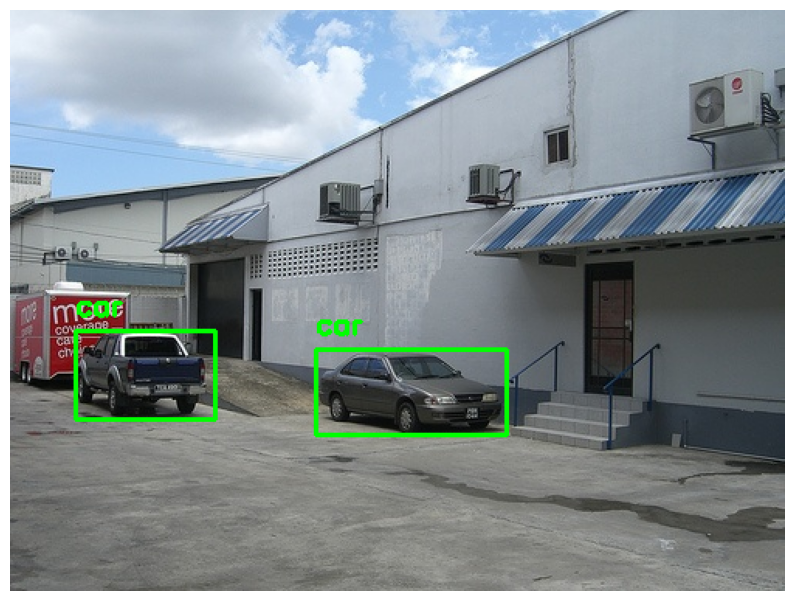

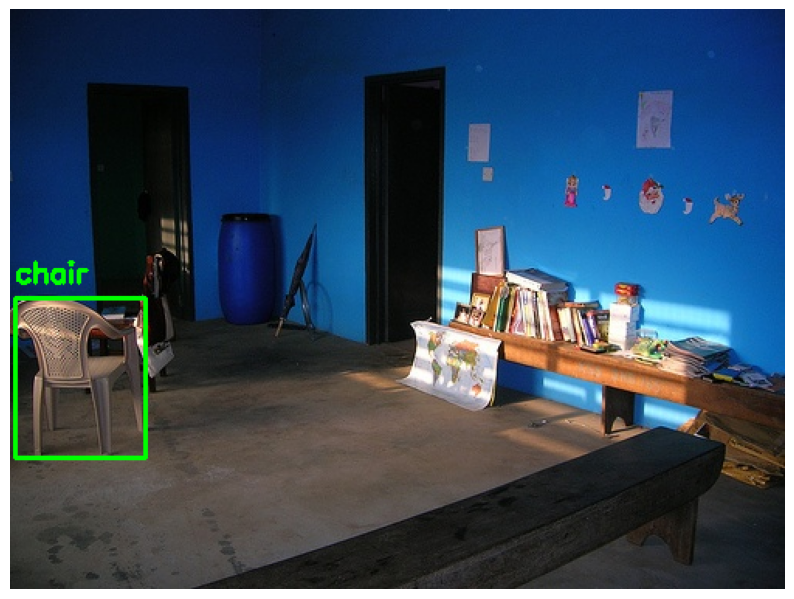

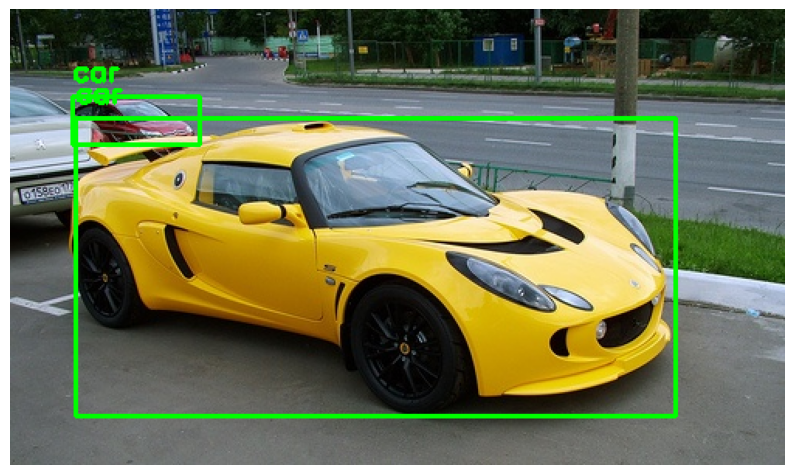

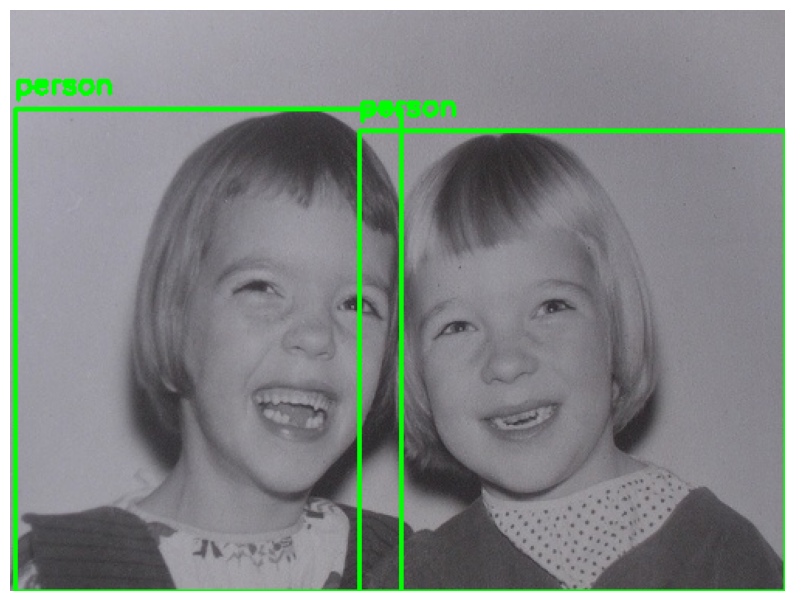

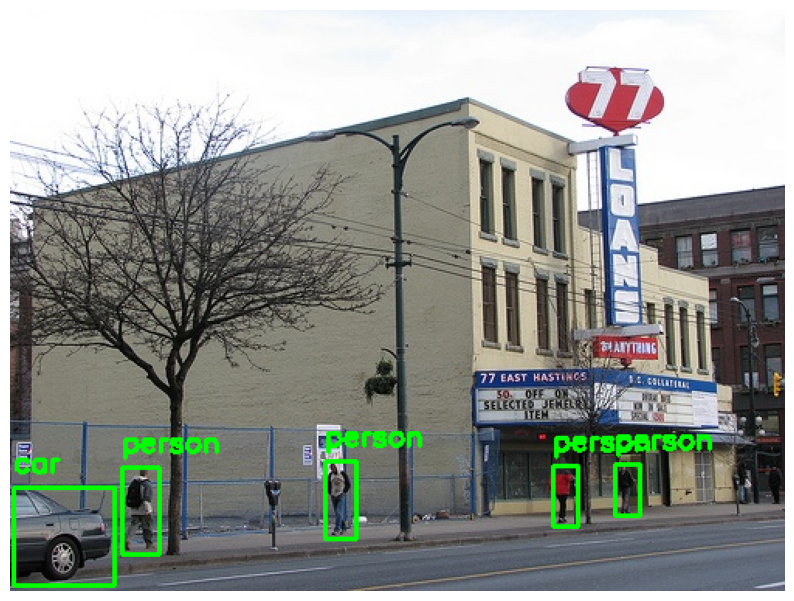

In [20]:
num_imgs_to_show = 5
random_images = random.sample(all_image_paths, num_imgs_to_show)

for img_path in random_images:
    show_verification_image(img_path)

After seeing the images each with its bounding boxes and images, it's safe to say that the boxes and labels line up correctly and the preprocessing was succesful.

* There may be in the image some object inside the detectable classes that doesn't have bounding box. This would simply mean that it was labelled as 'difficult' and is ignored in the representation.

* Some objects that fill almost entirely the image's area appear without a label, this is because the logic behind the representation of the labels is for them to appear 10 pixels above the bounding box (the label would be off the limits of the image in this specific case, then it doesn't appear).